In [1]:
from google.colab import drive
drive.mount('/content/a')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/a


In [2]:
import pandas as pd
from time import time
import numpy as np
from IPython.display import Image

import keras
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, LSTM, RepeatVector
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

from sklearn.cluster import KMeans, DBSCAN

Using TensorFlow backend.


In [0]:
filePath = 'a/My Drive/Research Data/TOP/probData/Prob_weekendaft.csv'
df_prob = pd.read_csv(filePath)
# df_prob

In [0]:
label = df_prob.iloc[:, 0]
feature_input = df_prob.iloc[:, 1:]

In [5]:
dims = [feature_input.shape[-1], 300, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_feature = Input(shape=(dims[0],), name='input')
    x = input_feature
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_feature, outputs=decoded, name='AE'), Model(inputs=input_feature, outputs=encoded, name='encoder')

In [0]:
autoencoder, encoder = autoencoder(dims, init=init)

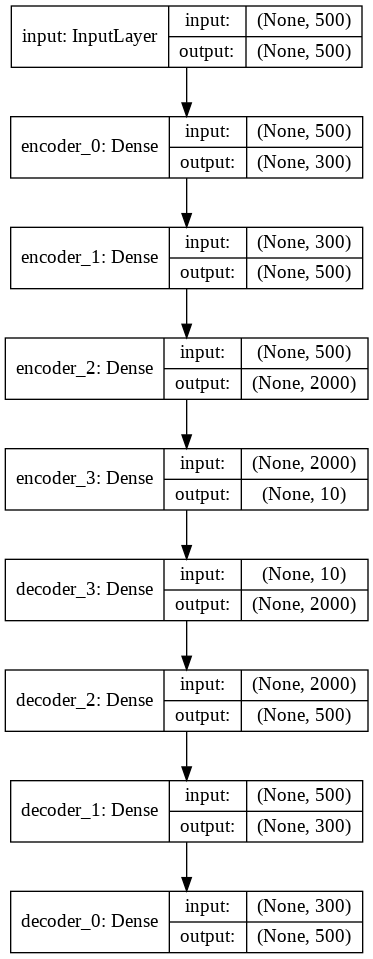

In [8]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png')

In [0]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(feature_input, feature_input, batch_size=batch_size, epochs=pretrain_epochs, verbose = 2) #, callbacks=cb)
autoencoder.save_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/ae_weights.h5')

In [0]:
autoencoder.load_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/ae_weights.h5')

In [0]:
y_pred = encoder.predict(feature_input)

# **Kmeans**

In [49]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(y_pred)
kmeans.labels_

array([0, 3, 3, ..., 3, 3, 3], dtype=int32)

In [0]:
result = pd.Series(kmeans.labels_)
df_result = label.to_frame()
df_result.loc[: ,"result"] = result

In [0]:
df_result.to_csv('a/My Drive/Research Data/TOP/AutoEncoder Clustering/result/AE+Kmeans/Cluster_label_weekdaymor.csv')

In [15]:
prob_dict = {}

for cluster_num in range(5):
    temp_list = np.zeros(shape=500)
    df_temp = df_result.loc[df_result.result==cluster_num]
    num_of_device = df_temp.shape[0]
    print(num_of_device)
    for marker in df_temp.label.values.tolist():
        temp_device = df_prob.loc[df_prob.label==marker].iloc[0, 1:].values
        temp_list = temp_list + temp_device
    prob_dict[str(cluster_num)] = temp_list/num_of_device

df_cluster_prob = pd.DataFrame(prob_dict)
df_cluster_prob.T.to_csv('a/My Drive/Research Data/TOP/AutoEncoder Clustering/result/AE+Kmeans/Cluster_prob_weekdaymor.csv')

993
639
414
200
471


In [35]:
df_cluster_prob.T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.884093,0.884081,0.884076,0.884074,0.867546,0.830627,0.798746,0.765645,0.737051,0.70973,...,0.00451018,0.00448221,0.00446484,0.00443275,0.00438922,0.00434317,0.00430709,0.00427411,0.0042324,0.00417324
1,1,1,1,1,0.997622,0.994077,0.989074,0.981874,0.969811,0.960302,...,0.334359,0.333866,0.333125,0.329307,0.3291,0.328902,0.328684,0.328489,0.327232,0.326936
2,1,1,1,1,0.991684,0.981184,0.970156,0.963465,0.958941,0.955666,...,0.00352182,0.00299328,0.00299328,0.00299328,0.00299328,0.00299328,0.00293945,0.0024109,0.0024109,0.0024109
3,1,1,1,1,0.990628,0.976436,0.962916,0.9472,0.932025,0.919424,...,0.064775,0.0642305,0.0637996,0.0634552,0.0623572,0.0618647,0.061465,0.0611598,0.0602078,0.0598659
4,1,1,1,0.999937,0.985504,0.961133,0.937777,0.915582,0.895882,0.876349,...,0.0165134,0.0164157,0.0163025,0.0162037,0.0161662,0.0160767,0.0158962,0.0157726,0.0156596,0.0154452


# **DBSCAN**

In [12]:
dbscan = DBSCAN(eps=0.5, min_samples=7).fit(y_pred)
dbscan.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
a = set(dbscan.labels_.tolist())
a

{-1, 0, 1}

In [0]:
result = pd.Series(dbscan.labels_)
df_result = label.to_frame()
df_result.loc[: ,"result"] = result
df_result.to_csv('a/My Drive/Research Data/TOP/AutoEncoder Clustering/result/AE+DBSCAN/Cluster_label_weekendaft.csv')

In [15]:
prob_dict = {}

for cluster_num in a:
    temp_list = np.zeros(shape=500)
    df_temp = df_result.loc[df_result.result==cluster_num]
    num_of_device = df_temp.shape[0]
    print(num_of_device)
    for marker in df_temp.label.values.tolist():
        temp_device = df_prob.loc[df_prob.label==marker].iloc[0, 1:].values
        temp_list = temp_list + temp_device
    prob_dict[str(cluster_num)] = temp_list/num_of_device

df_cluster_prob = pd.DataFrame(prob_dict)
df_cluster_prob.T.to_csv('a/My Drive/Research Data/TOP/AutoEncoder Clustering/result/AE+DBSCAN/Cluster_prob_weekendaft.csv')

1720
958
39


# **LSTM Test**

In [6]:
latent_dim = 10
timesteps = 500
input_dim = 10
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
encoder.summary()
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 500, 10)           0         
_________________________________________________________________
lstm_2 (LSTM

In [7]:
print(feature_input.shape)
lstm_input = feature_input.values[:, :, np.newaxis]
print(lstm_input.shape)

(2717, 500)
(2717, 500, 1)


In [0]:
adam_opti = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sequence_autoencoder.compile(optimizer=adam_opti, loss='mse')
sequence_autoencoder.fit(lstm_input, lstm_input, batch_size=batch_size, epochs=pretrain_epochs, verbose = 2) #, callbacks=cb)
sequence_autoencoder.save_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/lstm_weights.h5')

In [0]:
sequence_autoencoder.load_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/lstm_weights.h5')
y_pred = encoder.predict(lstm_input)

# **LSTM script**

In [0]:
input_file_path = 'a/My Drive/Research Data/TOP/probData/LSTM/Prob/Prob_{}_{}.csv'
kmeans_out = 'a/My Drive/Research Data/TOP/probData/LSTM/LSTM+Kmeans/{}_LSTM_Kmeans_{}_{}.csv'
dbscan_out = 'a/My Drive/Research Data/TOP/probData/LSTM/LSTM+DBSCAN/{}_LSTM_DBSCAN_{}_{}.csv'

weekList = ['weekday_mor', 'weekday_aft', 'weekend_mor', 'weekend_aft']
monthList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
cluster_num = [5]#[6, 7]
eps_List = [0.2, 0.3, 1.3]

porb_in_Path = 'a/My Drive/Research Data/TOP/probData/M10/{}.csv'

In [0]:
def auto_LSTM(input_file_path, monthList, weekName):
    dfList = []
    for monthName in monthList:
        df_temp = pd.read_csv(input_file_path.format(monthName, weekName), index_col=0)
        dfList.append(df_temp)
        
    lstm_input = np.empty([2717, 10, 500])
    for ii in range(2717):
        for iii in range(10):
            lstm_input[ii, iii] = dfList[iii].iloc[ii, :].values
    lstm_input = lstm_input.transpose((0, 2, 1))
    
    # create model
    latent_dim = 10
    timesteps = 500
    input_dim = 10
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    encoder.summary()
    sequence_autoencoder.summary()
    
    pretrain_epochs = 200
    batch_size = 256
    adam_opti = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    sequence_autoencoder.compile(optimizer=adam_opti, loss='mse')
    sequence_autoencoder.fit(lstm_input, lstm_input, batch_size=batch_size, epochs=pretrain_epochs, verbose = 2) #, callbacks=cb)
    sequence_autoencoder.save_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/lstm_weights.h5')
    
    sequence_autoencoder.load_weights('a/My Drive/Research Data/TOP/AutoEncoder Clustering/lstm_weights.h5')
    y_pred = encoder.predict(lstm_input)
    
    return y_pred

def auto_kmeans(y_pred, cluster_core, label_output, prob_output, label, df_prob):
    kmeans = KMeans(n_clusters=cluster_core, random_state=0).fit(y_pred)
    result = pd.Series(kmeans.labels_)
    df_label = label.to_frame()
    df_label.loc[: ,"result"] = result
    df_label.to_csv(label_output)
    prob_dict = {}

    for cluster_num in range(cluster_core):
        temp_list = np.zeros(shape=500)
        df_temp = df_label.loc[df_label.result==cluster_num]
        num_of_device = df_temp.shape[0]
        print(num_of_device)
        for marker in df_temp.street_marker.values.tolist():
            temp_device = df_prob.loc[df_prob.street_marker==marker].iloc[0, 1:].values
            temp_list = temp_list + temp_device
        prob_dict[str(cluster_num)] = temp_list/num_of_device

    df_cluster_prob = pd.DataFrame(prob_dict)
    df_cluster_prob.T.to_csv(prob_output)    
    
def auto_dbscan(y_pred, eps_val, label_output, prob_output, label, df_prob):
    dbscan = DBSCAN(eps=eps_val, min_samples=7).fit(y_pred)
    a = set(dbscan.labels_.tolist())
    
    result = pd.Series(dbscan.labels_)
    df_label = label.to_frame()
    df_label.loc[: ,"result"] = result
    df_label.to_csv(label_output)

    prob_dict = {}
    for cluster_num in a:
        temp_list = np.zeros(shape=500)
        df_temp = df_label.loc[df_label.result==cluster_num]
        num_of_device = df_temp.shape[0]
        print(num_of_device)
        for marker in df_temp.street_marker.values.tolist():
            temp_device = df_prob.loc[df_prob.street_marker==marker].iloc[0, 1:].values
            temp_list = temp_list + temp_device
        prob_dict[str(cluster_num)] = temp_list/num_of_device

    df_cluster_prob = pd.DataFrame(prob_dict)
    df_cluster_prob.T.to_csv(prob_output)

In [5]:
for weekName in weekList:
    reference_path = porb_in_Path.format(weekName)

    print("Start reading file: " + reference_path)
    df_prob = pd.read_csv(reference_path)
    label = df_prob.iloc[:, 0]
    feature_input = df_prob.iloc[:, 1:]

    y_pred = auto_LSTM(input_file_path, monthList, weekName)

    for cluster_core in cluster_num:
        kmeans_label_output = kmeans_out.format('label', weekName, cluster_core)
        kmeans_prob_output = kmeans_out.format('prob', weekName, cluster_core)
        auto_kmeans(y_pred, cluster_core, kmeans_label_output, kmeans_prob_output, label, df_prob)
        
    for eps_val in eps_List:   
        dbscan_label_output = dbscan_out.format('label', weekName, eps_val)
        dbscan_prob_output = dbscan_out.format('prob', weekName, eps_val)
        auto_dbscan(y_pred, cluster_core, dbscan_label_output, dbscan_prob_output, label, df_prob)

    print("Finish processing file: " + reference_path)

Start reading file: a/My Drive/Research Data/TOP/probData/M10/weekday_mor.csv
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
Total params: 840
Trainable params: 840
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
____________________________________________________________